In [1]:
from sklearn import datasets
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np
import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, Bridge_MLP_mean
from entot.plotting.plots import plot_1D_balanced
import anndata as ad

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-08-03 14:32:56.911905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata_atac = ad.read_h5ad("../../data/bone_marrow_atac.h5ad")
adata_rna = ad.read_h5ad("../../data/bone_marrow_rna.h5ad")

In [3]:
source = adata_atac.obsm["ATAC_lsi_red"]
target = adata_rna.obsm["GEX_X_pca"]

In [4]:
source.shape, target.shape

((6224, 38), (6224, 50))

In [6]:
from sklearn.decomposition import PCA
source_red = PCA(10).fit_transform(source)
target_red = PCA(10).fit_transform(target)


In [7]:
source_red.shape, target_red.shape

((6224, 10), (6224, 10))

In [8]:
neural_net = MLP_vector_field(10, 64, 64, 64)
bridge_net = Bridge_MLP_mean(10, 32, 32)
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=1e-2)

otfm = OTFlowMatching(neural_net, bridge_net, input_dim=10, output_dim=10, iterations=10_000, ot_solver=solver, k_noise_per_x=10)

2023-08-03 14:34:45.975155: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [19]:
otfm(source_red, target_red, 800, 800)

  8%|▊         | 758/10000 [24:00<4:52:41,  1.90s/it] 


KeyboardInterrupt: 

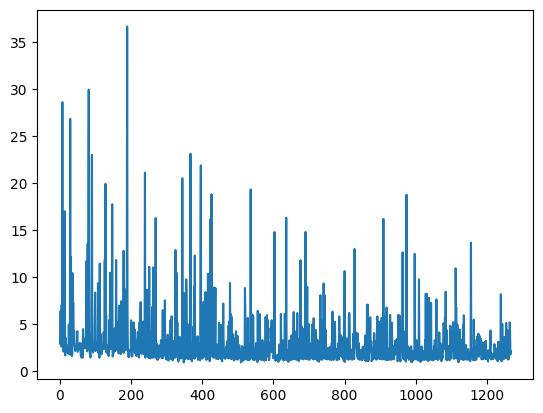

In [18]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

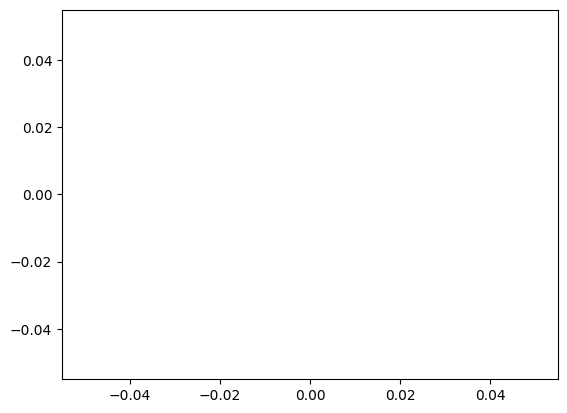

In [12]:
plt.plot(np.arange(len(otfm.metrics["loss"][5000:])), otfm.metrics["loss"][5000:])

In [14]:
gex_predicted,_, _ = otfm.transport(source, seed=0)

In [10]:
import scanpy as sc
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[0,...], target_red), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

ImportError: Numba needs NumPy 1.24 or less

In [15]:
import scipy
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [17]:
import scipy 
foscttm(gex_predicted[0,...], target)

0.5023

In [64]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_red, seed=i)[0][0,...]

In [65]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [66]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

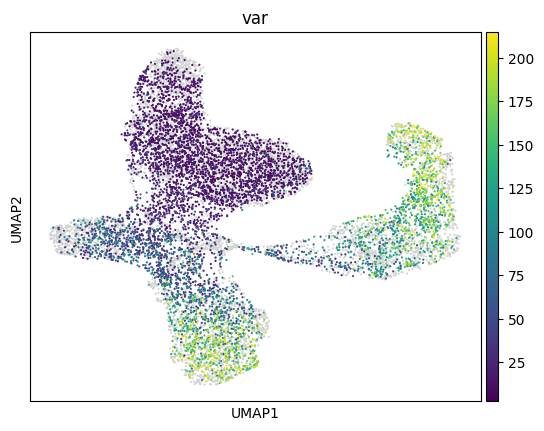

In [67]:
sc.pl.umap(adata, color="var", vmax="p99")

In [68]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,57.884080
CD4+ T activated,14.830571
CD4+ T naive,14.419965
CD8+ T,64.696569
CD14+ Mono,9.575228
CD16+ Mono,15.864909
Erythroblast,125.064274
G/M prog,19.686775
HSC,17.042239


In [32]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,83.601758
CD4+ T activated,19.568209
CD4+ T naive,19.001598
CD8+ T,77.620642
CD14+ Mono,11.951774
CD16+ Mono,12.951762
Erythroblast,131.598336
G/M prog,28.517488
HSC,22.957683


In [33]:
sc.tl.dendrogram(adata, groupby="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


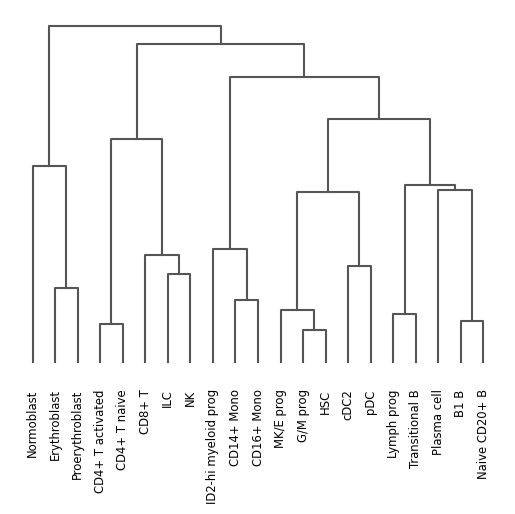

<Axes: >

In [35]:
sc.pl.dendrogram(adata, groupby="cell_type")

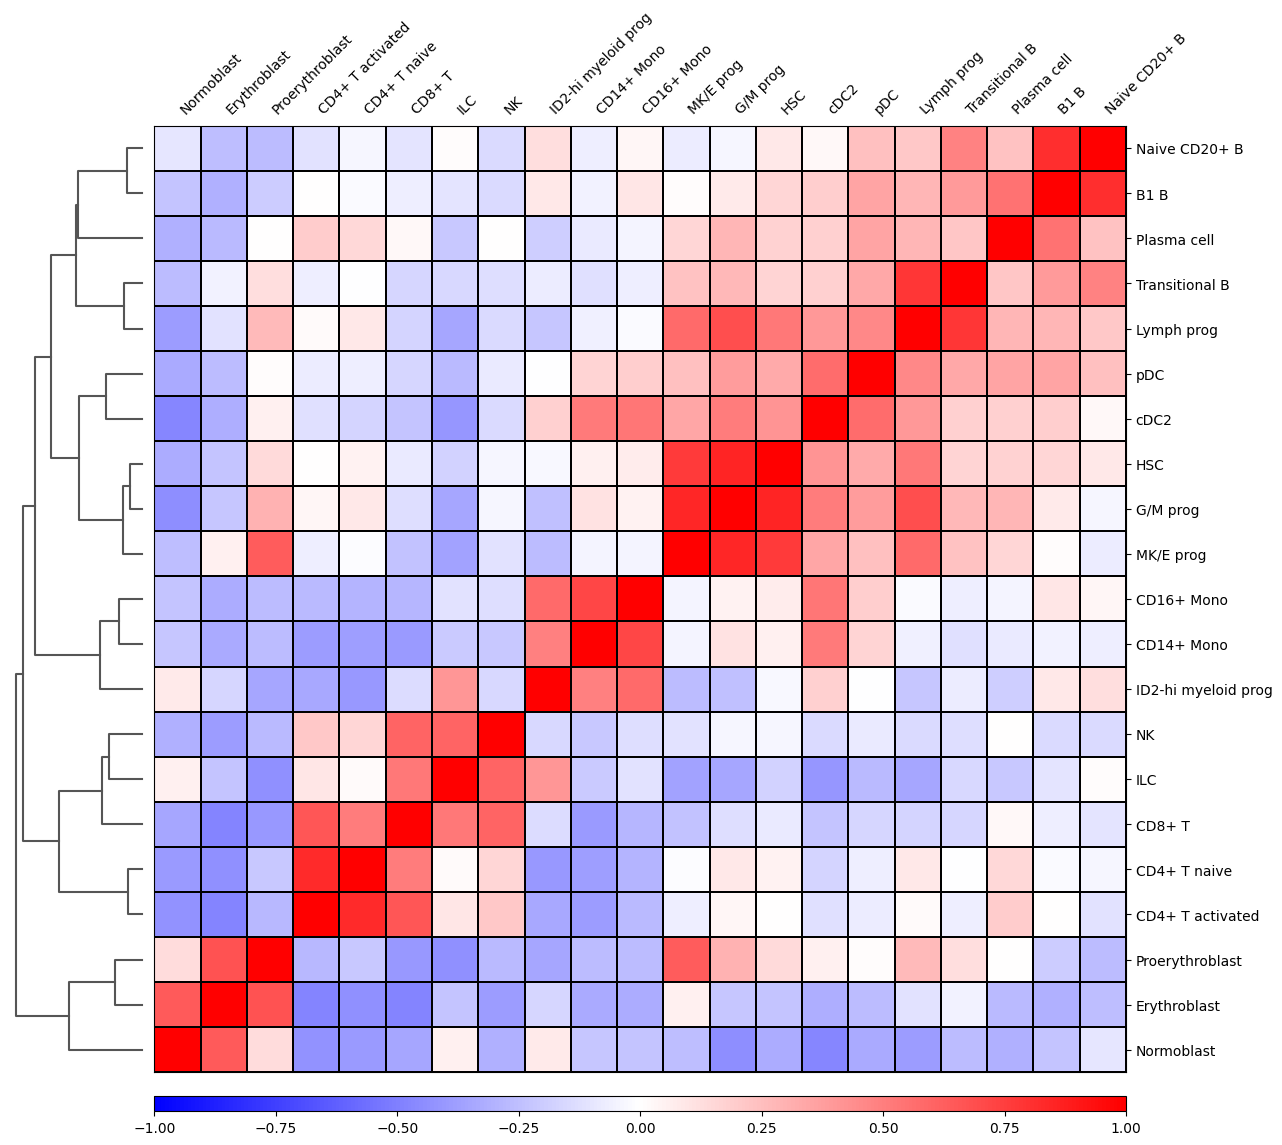

In [37]:
sc.pl.correlation_matrix(adata, groupby="cell_type")